In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

import warnings
warnings.filterwarnings('ignore')

fontsize = 14
params = {'axes.labelsize': fontsize,
          'font.size': fontsize,
          'legend.fontsize': fontsize,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'figure.figsize': (15, 10)}
plt.rcParams.update(params)

In [2]:
root_path = os.path.join('..', '..', 'cleaned_logs_to_keep', 'local', 'same_edges')
filenames = ['same_edges1.csv', 'same_edges2.csv']

In [3]:
comparison_list = []

for filename in filenames:
    comparison = pd.read_csv(os.path.join(root_path, filename))
    comparison['end_of_command'] = pd.to_datetime(comparison['end_of_command'])
    comparison['duration'] = comparison['end_of_command'].diff().dt.total_seconds()
    comparison['edge_per_node'] = comparison['edge_per_node'] * 2
    comparison['duration'].fillna(0, inplace=True)
    comparison_list.append(comparison)
    
comparison_average = comparison_list[0].copy()
comparison_average['duration'] = (comparison_average['duration'] + comparison_list[1]['duration']) / 2

In [4]:
comparison_group_by = comparison_average[['edge_per_node', 'duration']].groupby(by='edge_per_node').sum()

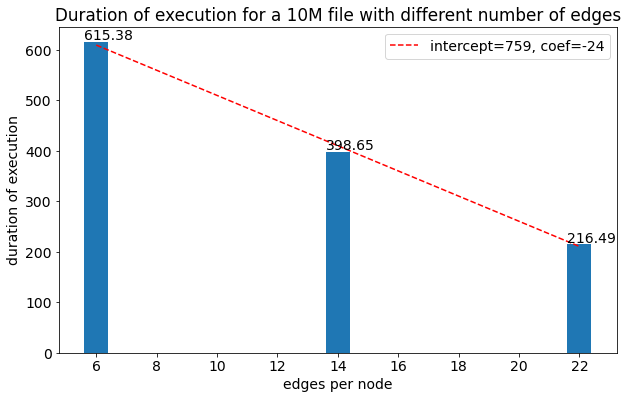

In [5]:
def plot_total_duration(comparison_group_by, title):
    
    lin_reg = LinearRegression()
    lin_reg.fit(comparison_group_by.T.columns.to_numpy().reshape(-1, 1), comparison_group_by.T.loc['duration'])
    x = np.arange(min(comparison_group_by.T.columns), max(comparison_group_by.T.columns) + 1)
    y = x * lin_reg.coef_ + lin_reg.intercept_

    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(10)
    ax.bar(comparison_group_by.T.columns, height=comparison_group_by.T.loc['duration'])
    ax.set_xlabel('edges per node')
    ax.set_ylabel('duration of execution')
    ax.set_title(title)
    ax.plot(x, y, 'r--', label=f"intercept={int(lin_reg.intercept_)}, coef={int(lin_reg.coef_)}")
    ax.set_xticks(np.arange(min(comparison_group_by.T.columns), max(comparison_group_by.T.columns) + 1, 2.0))
    ax.legend()

    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x(), p.get_height() * 1.01))
        
    plt.show()
    
    
plot_total_duration(comparison_group_by, 'Duration of execution for a 10M file with different number of edges')

In [6]:
edges_3 = comparison_average[comparison_average['edge_per_node'] == 6]
edges_7 = comparison_average[comparison_average['edge_per_node'] == 14]
edges_11 = comparison_average[comparison_average['edge_per_node'] == 22]

edges_3.reset_index(inplace=True)
edges_7.reset_index(inplace=True)
edges_11.reset_index(inplace=True)

In [7]:
edges_3_cmd = edges_3.groupby(by=['command']).sum()
edges_7_cmd = edges_7.groupby(by=['command']).sum()
edges_11_cmd = edges_11.groupby(by=['command']).sum()

edges_3_cmd.drop(['start'], axis=0, inplace=True)
edges_7_cmd.drop(['start'], axis=0, inplace=True)
edges_11_cmd.drop(['start'], axis=0, inplace=True)

In [8]:
edges_3_cmd

,index,edge_per_node,loop_counter,accum,duration
command,,,,,
ded_groupby,161,42,28,52160844,238.601948
ded_map,154,42,28,34773896,43.241052
ded_reduce,168,42,28,52160844,84.596182
it_groupby,140,42,28,0,123.544867
it_map,133,42,28,0,95.018553
it_reduce,147,42,28,17386948,30.374837


In [9]:
def sort_commands(df):
    
    df['order'] = 0
    df.loc['it_map', 'order'] = 1
    df.loc['it_groupby', 'order'] = 2
    df.loc['it_reduce', 'order'] = 3
    df.loc['ded_map', 'order'] = 4
    df.loc['ded_groupby', 'order'] = 5
    df.loc['ded_reduce', 'order'] = 6
    df['command'] = df.index.values
    df.sort_values(by='order', inplace=True)
    df.set_index(['order'], inplace=True)
    return df

edges_3_cmd = sort_commands(edges_3_cmd)
edges_7_cmd = sort_commands(edges_7_cmd)
edges_11_cmd = sort_commands(edges_11_cmd)

In [10]:
edges_3_cmd['vs_edge_7'] = edges_3_cmd['duration'] / edges_7_cmd['duration']
edges_3_cmd['vs_edge_11'] = edges_3_cmd['duration'] / edges_11_cmd['duration']

edges_7_cmd['vs_edge_3'] = edges_7_cmd['duration'] / edges_3_cmd['duration']
edges_7_cmd['vs_edge_11'] = edges_7_cmd['duration'] / edges_11_cmd['duration']

edges_11_cmd['vs_edge_3'] = edges_11_cmd['duration'] / edges_3_cmd['duration']
edges_11_cmd['vs_edge_7'] = edges_11_cmd['duration'] / edges_7_cmd['duration']

In [11]:
durations = pd.DataFrame(edges_3_cmd[['command', 'duration']], index=edges_3_cmd.index)
durations = durations.merge(edges_7_cmd[['duration']], left_index=True, right_index=True)
durations = durations.merge(edges_11_cmd[['duration']], left_index=True, right_index=True)
durations.rename({'duration': 'edge_11', 'duration_x': 'edge_3', 'duration_y': 'edge_7'}, axis=1, inplace=True)
durations = durations[['command', 'edge_3', 'edge_7', 'edge_11']]
durations.set_index('command', inplace=True)
durations

,edge_3,edge_7,edge_11
command,,,
it_map,95.018553,63.017937,24.462318
it_groupby,123.544867,79.143736,32.413790
it_reduce,30.374837,14.965009,10.473073
ded_map,43.241052,24.097973,17.642850
ded_groupby,238.601948,157.722372,110.212191
ded_reduce,84.596182,55.769055,17.455307


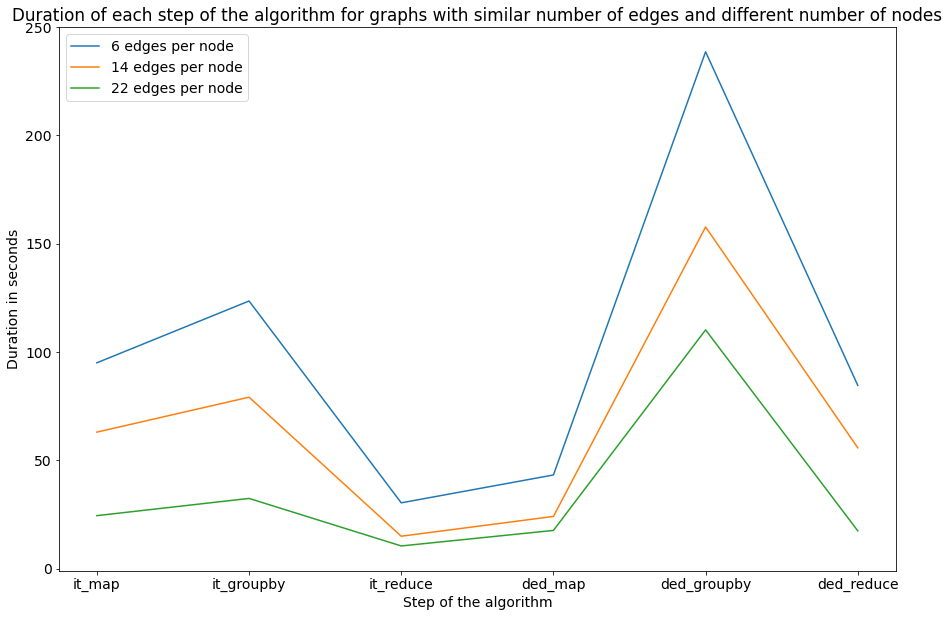

In [12]:
plt.plot(durations['edge_3'], label="6 edges per node")
plt.plot(durations['edge_7'], label="14 edges per node")
plt.plot(durations['edge_11'], label="22 edges per node")
plt.title("Duration of each step of the algorithm for graphs with similar number of edges and different number of nodes")
plt.xlabel("Step of the algorithm")
plt.ylabel("Duration in seconds")
plt.legend();

In [13]:
root_path = os.path.join('..', '..', 'cleaned_logs_to_keep', 'local', 'same_nodes')
filenames = ['same_nodes1.csv', 'same_nodes2.csv']

In [14]:
comparison_list = []

for filename in filenames:
    comparison = pd.read_csv(os.path.join(root_path, filename))
    comparison['end_of_command'] = pd.to_datetime(comparison['end_of_command'])
    comparison['duration'] = comparison['end_of_command'].diff().dt.total_seconds()
    comparison['edge_per_node'] = comparison['edge_per_node'] * 2
    comparison['duration'].fillna(0, inplace=True)
    comparison_list.append(comparison)
    
comparison_average = comparison_list[0].copy()
comparison_average['duration'] = (comparison_average['duration'] + comparison_list[1]['duration']) / 2

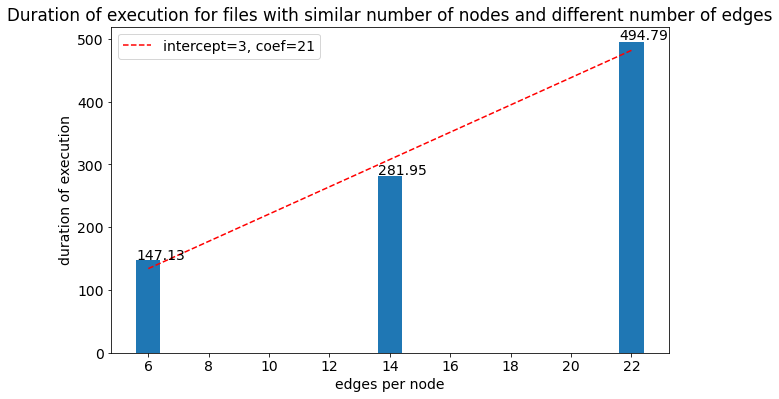

In [15]:
comparison_group_by = comparison_average[['edge_per_node', 'duration']].groupby(by='edge_per_node').sum()
plot_total_duration(comparison_group_by, "Duration of execution for files with similar number of nodes and different number of edges")

In [16]:
edges_3 = comparison_average[comparison_average['edge_per_node'] == 6]
edges_7 = comparison_average[comparison_average['edge_per_node'] == 14]
edges_11 = comparison_average[comparison_average['edge_per_node'] == 22]

edges_3.reset_index(inplace=True)
edges_7.reset_index(inplace=True)
edges_11.reset_index(inplace=True)

edges_3_cmd = edges_3.groupby(by=['command']).sum()
edges_7_cmd = edges_7.groupby(by=['command']).sum()
edges_11_cmd = edges_11.groupby(by=['command']).sum()

edges_3_cmd.drop(['start'], axis=0, inplace=True)
edges_7_cmd.drop(['start'], axis=0, inplace=True)
edges_11_cmd.drop(['start'], axis=0, inplace=True)

edges_3_cmd = sort_commands(edges_3_cmd)
edges_7_cmd = sort_commands(edges_7_cmd)
edges_11_cmd = sort_commands(edges_11_cmd)

In [17]:
durations = pd.DataFrame(edges_3_cmd[['command', 'duration']], index=edges_3_cmd.index)
durations = durations.merge(edges_7_cmd[['duration']], left_index=True, right_index=True)
durations = durations.merge(edges_11_cmd[['duration']], left_index=True, right_index=True)
durations.rename({'duration': 'edge_11', 'duration_x': 'edge_3', 'duration_y': 'edge_7'}, axis=1, inplace=True)
durations = durations[['command', 'edge_3', 'edge_7', 'edge_11']]
durations.set_index('command', inplace=True)
durations

,edge_3,edge_7,edge_11
command,,,
it_map,17.177779,33.704642,85.501525
it_groupby,26.846197,46.132454,98.881963
it_reduce,12.386680,15.627408,15.535346
ded_map,18.157523,24.987020,26.580357
ded_groupby,59.643194,132.309139,190.369393
ded_reduce,12.922312,25.282801,73.656913


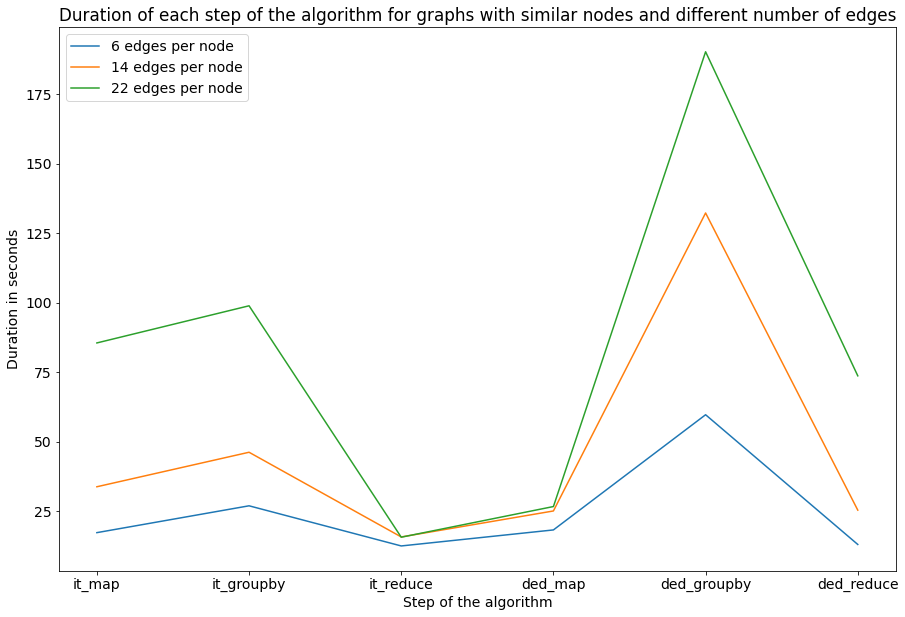

In [18]:
plt.plot(durations['edge_3'], label="6 edges per node")
plt.plot(durations['edge_7'], label="14 edges per node")
plt.plot(durations['edge_11'], label="22 edges per node")
plt.title("Duration of each step of the algorithm for graphs with similar nodes and different number of edges")
plt.xlabel("Step of the algorithm")
plt.ylabel("Duration in seconds")
plt.legend();